# IdpGAN example

Welcome to the idpGAN example notebook. IdpGAN is a [GAN](), a type of [deep generative model](), trained to generate ensembles of 3D conformations of [coarse grained](https://pubmed.ncbi.nlm.nih.gov/27333362/) (CG) protein molecules.

In this notebook, we will use idpGAN to generate conformational ensembles of CG [intrinsically disordered proteins](https://en.wikipedia.org/wiki/Intrinsically_disordered_proteins) (IDPs).

For more details on idpGAN, please refer to: [Direct generation of protein conformational ensembles via machine learning](https://link.to.article.todo).

For its source code, see: [idpGAN GitHub repository](https://link.to.github.todo).

# 1 - Setup the environment
Install the dependencies for this notebook. Needed to run the rest of the notebook.

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch

from idpgan.data import parse_fasta_seq
from idpgan.nn_models import load_netg_article
from idpgan.plot import (plot_average_dmap_comparison, plot_cmap_comparison,
                         plot_rg_comparison, plot_distances_comparison,
                         plot_rg_distribution, plot_dmap_snapshots)
from idpgan.evaluation import (score_mse_d, score_mse_c,
                               score_akld_d, score_kl_approximation)

# import importlib
# import module
# importlib.reload(module)
# from module import module_class

Setup the device in which we want to run the PyTorch models.

In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("- Using device '%s'" % device)

- Using device 'cpu'


# 2 - Example proteins
Follow this section to see how the idpGAN generator works and how to use it.

## Load reference CG MD data

First of all, we will load the molecular dynamics (MD) data for two example IDPs, named `protan` and `protac`. Both proteins were not present in the training set of idpGAN and they belong to its test set.

Later, we will use idpGAN to generate conformational ensembles for the same IDPs and we will compare the MD and the generated ensembles. 

If you are interested into the details about these MD simulations and the CG model and force field used for them, please refer to the [idpGAN article]().

In [3]:
data_dp = "../data"

In [4]:
# TODO: delete
# from idp_lib.data import get_idp_mdtraj
# traj = get_idp_mdtraj(traj_dp="/feig/s1/gilberto/ml_data/protac/5000_FRAMES/",
#                       top_fp="/feig/s1/gilberto/ml_data/protac/protein.pdb",
#                       filter_fn=lambda fn: (fn.startswith("protein.prod") and fn.endswith("dcd")))
# np.save("protac.npy", traj.xyz)

### Load protan and protac data

The MD conformational ensembles for both IDPs are stored in NumPy arrays with shape `(N, L, 3)`.

Here `N` is the number of snapshots in the ensemble.

`L` is the number of residues in the protein. In our CG model each residue is represented by one "atom" or "bead". Note that both proteins have 55 residues.

The last axis (with dimension `3`) stores the xyz coordinates of the bead. The coordinates are expressed in units of nm.

In [5]:
# Load amino acid sequences.
seq_protan = parse_fasta_seq(os.path.join(data_dp, "protan.fasta"))
seq_protac = parse_fasta_seq(os.path.join(data_dp, "protac.fasta"))

print("- protan sequence:", seq_protan)
print("- protac sequence:", seq_protac)

# Load xyz data of the MD conformational ensembles.
xyz_protan_md = np.load(os.path.join(data_dp, "protan.npy"))
xyz_protac_md = np.load(os.path.join(data_dp, "protac.npy"))

print("\n- protan md xyz data:", xyz_protan_md.shape)
print("- protac md xyz data:", xyz_protac_md.shape)

- protan sequence: CDAAVDTSSEITTKDLKEKKEVVEEAENGRDAPANGNANEENGEQEADNEVDEEC
- protac sequence: CEEGGEEEEEEEEGDGEEEDGDEDEEAESATGKRAAEDDEDDDVDTKKQKTDEDC

- protan md xyz data: (25000, 55, 3)
- protac md xyz data: (25000, 55, 3)


### Load poly-alanine data

We will also load MD data for a poly-alanine (`polyala`) molecule having the same number of residues of `protan` and `protac`.

In our CG MD simulations, a poly-alanine molecule behaves as a simple random linear polymer.

We will use its conformational ensemble as a naive approximation for the ensemble of our two IDPs.

In [6]:
seq_polyala = parse_fasta_seq(os.path.join(data_dp, "polyala.fasta"))
print("- polyala sequence:", seq_polyala)

xyz_polyala_md = np.load(os.path.join(data_dp, "polyala.npy"))
print("\n- polyala md xyz data:", xyz_polyala_md.shape)

- polyala sequence: AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA

- polyala md xyz data: (25000, 55, 3)


## Generate conformational ensembles with idpGAN

Here we will generate conformational ensembles with the generator network of idpGAN.

### Load the model and its weights

In [38]:
netg = load_netg_article(model_fp=os.path.join(data_dp, "generator.pt"),
                         device=device)

### Actually generates the ensembles

In [39]:
n_samples = 10000

Let's first generated the ensembles for `protan` and `protac`.

We will generate ensembles with `n_samples` conformations in them.

Also, let's time the speed of the generator network. If you are running the notebook on a GPU, it should be quite fast (on a NVIDIA Quadro RTX 6000 it takes about 600 ms to generate 10000 conformations).

In [40]:
%%time
xyz_protan_gen = netg.predict_idp(n_samples=n_samples, aa_seq=seq_protan,
                                  device=device).cpu().numpy()
print("- protan generated xyz data:", xyz_protan_gen.shape)

- protan generated xyz data: (10000, 55, 3)
CPU times: user 2min 25s, sys: 23.2 s, total: 2min 48s
Wall time: 7.39 s


In [41]:
%%time
xyz_protac_gen = netg.predict_idp(n_samples=n_samples, aa_seq=seq_protac,
                                  device=device).cpu().numpy()
print("- protac generated xyz data:", xyz_protac_gen.shape)

- protac generated xyz data: (10000, 55, 3)
CPU times: user 2min 19s, sys: 20.2 s, total: 2min 39s
Wall time: 6.91 s


Finally, let's also generate and ensemble for our `polyala` molecule.

It will be interesting to see if idpGAN is able to model this artificial sequence (idpGAN was trained only with naturally-occuring amino acid sequences of IDPs).

In [11]:
%%time
xyz_polyala_gen = netg.predict_idp(n_samples=n_samples, aa_seq=seq_polyala,
                                   device=device).cpu().numpy()
print("- polyala generated xyz data:", xyz_protac_gen.shape)

- polyala generated xyz data: (10000, 55, 3)
CPU times: user 507 ms, sys: 63.9 ms, total: 571 ms
Wall time: 571 ms


## Analyze the MD and generated ensembles

Let's check some of the properties of the conformational ensembles.

We will compare the generated conformational ensembles with the corresponding MD ones.

### Distance maps

First let's plot the average [distance maps](https://en.wikipedia.org/wiki/Euclidean_distance_matrix) for all the ensembles.

In the **lower triangles** of the matrices, we will plot the MD data. In the **upper triangles**, the generated data.

In our CG model, the average MD distance maps appear as similar, but by looking at the color intensities, you can spot clear differences.

For all three proteins, the idpGAN ensembles have very similar distance maps with respect to the MD ones.

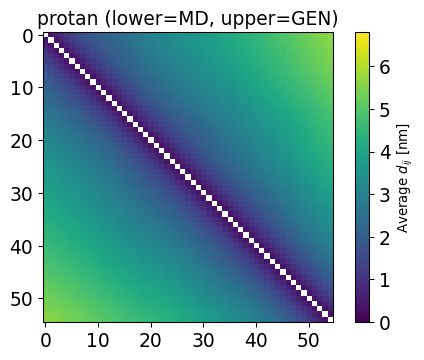

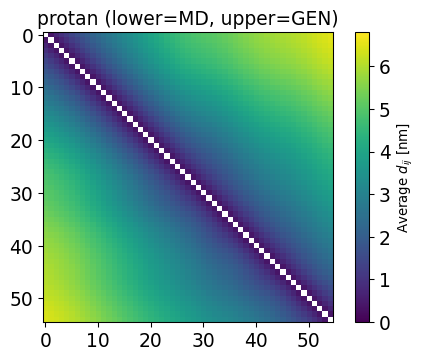

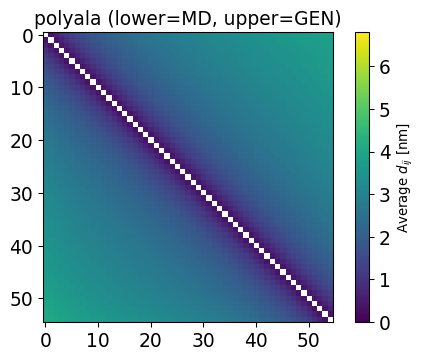

In [12]:
def get_distance_matrix(xyz):
    """
    Gets an ensemble of xyz conformations with shape (N, L, 3) and
    returns the corresponding distance matrices with shape (N, L, L).
    """
    return np.sqrt(np.sum(np.square(xyz[:,None,:,:]-xyz[:,:,None,:]), axis=3))

# Protan.
dmap_protan_md = get_distance_matrix(xyz_protan_md)
dmap_protan_gen = get_distance_matrix(xyz_protan_gen)
plot_average_dmap_comparison(dmap_protan_md,
                             dmap_protan_gen,
                             title="protan (lower=MD, upper=GEN)")

# Protac.
dmap_protac_md = get_distance_matrix(xyz_protac_md)
dmap_protac_gen = get_distance_matrix(xyz_protac_gen)
plot_average_dmap_comparison(dmap_protac_md,
                             dmap_protac_gen,
                             title="protan (lower=MD, upper=GEN)")

# Polyala.
dmap_polyala_md = get_distance_matrix(xyz_polyala_md)
dmap_polyala_gen = get_distance_matrix(xyz_polyala_gen)
plot_average_dmap_comparison(dmap_polyala_md,
                             dmap_polyala_gen,
                             title="polyala (lower=MD, upper=GEN)")

Let's also evaluate quantitatively the similarity between the average distance maps.

We will use *MSE_d* score (for more information, see the [idpGAN paper]()) expressed as:

$MSE_d = \frac{1}{N_{pairs}} \sum_{i<j} (m_{ij} - \hat{m}_{ij})^2,$

where $N_{pairs}$ is the number of all interatomic distances in a molecule, $i$ and $j$ are atom indices, $m_{ij}$ and $\hat{m}_{ij}$ are average interatomic distances in the MD ensemble and the "predicted" one used for approximation.

We first compute *MSE_d* scores between the MD ensembles of `polyala` with the ones of `protan` and `protac`, as a form of a simple approximation strategy for these two ensembles.

In [13]:
print("MSE_d polyala MD vs protan MD:", score_mse_d(dmap_protan_md.mean(axis=0),
                                                    dmap_polyala_md.mean(axis=0)))
print("MSE_d polyala MD vs protac MD:", score_mse_d(dmap_protac_md.mean(axis=0),
                                                    dmap_polyala_md.mean(axis=0)))

MSE_d polyala MD vs protan MD: 0.4767299
MSE_d polyala MD vs protac MD: 1.2709035


We then compute the *MSE_d* score of the idpGAN ensembles of `protan` and `protac` with the corresponding MD ones. Clearly, idpGAN provides better approximations (lower `MSE_d` scores) with respect to `polyala` data.

In [14]:
print("MSE_d protan GEN vs protan MD:", score_mse_d(dmap_protan_md.mean(axis=0),
                                                    dmap_protan_gen.mean(axis=0)))
print("MSE_d protac GEN vs protac MD:", score_mse_d(dmap_protac_md.mean(axis=0),
                                                    dmap_protac_gen.mean(axis=0)))

MSE_d protan GEN vs protan MD: 0.001889028
MSE_d protac GEN vs protac MD: 0.008130869


### Contact maps

Now let's plot the [contact maps](https://en.wikipedia.org/wiki/Protein_contact_map) of the three ensembles.

Just like before, in the **lower triangles** we plot the data for the MD ensembles, in the **upper triangles** data for the generated ensembles.

The MD maps are quite different between one ensemble and the other. This is because different amino acid compositions influence the dynamics of the three molecules. Note for example that the `polyala` map is quite homogeneous. On the other hand, `protan` and `protac` have some clear patterns caused by stretched of charged residues.

We can see that idpGAN captures the main patterns of each MD contact map.

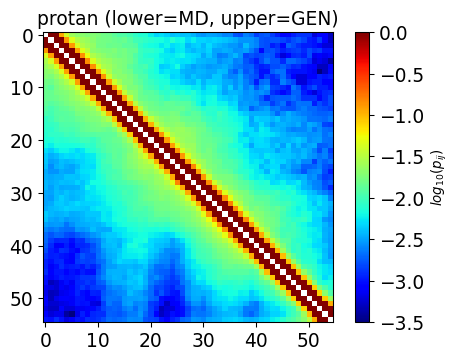

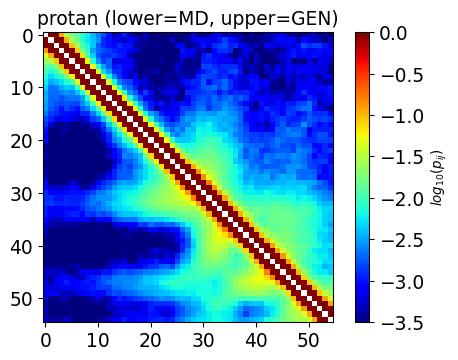

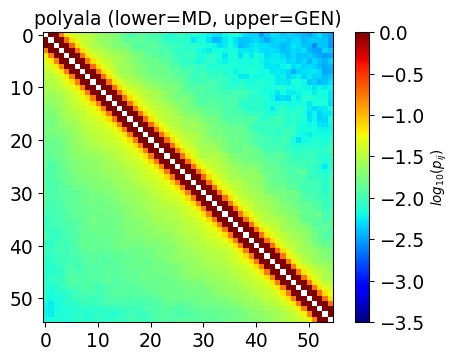

In [15]:
def get_contact_map(dmap, threshold=0.8, pseudo_count=0.01):
    """
    Gets a trajectory of distance maps with shape (N, L, L) and
    returns a (L, L) contact probability map.
    """
    n = dmap.shape[0]
    cmap = ((dmap <= threshold).astype(int).sum(axis=0)+pseudo_count)/n
    return cmap


# Protan.
cmap_protan_md = get_contact_map(dmap_protan_md)
cmap_protan_gen = get_contact_map(dmap_protan_gen)
plot_cmap_comparison(cmap_protan_md,
                     cmap_protan_gen,
                     title="protan (lower=MD, upper=GEN)")

# Protac.
cmap_protac_md = get_contact_map(dmap_protac_md)
cmap_protac_gen = get_contact_map(dmap_protac_gen)
plot_cmap_comparison(cmap_protac_md,
                     cmap_protac_gen,
                     title="protan (lower=MD, upper=GEN)")

# Polyala.
cmap_polyala_md = get_contact_map(dmap_polyala_md)
cmap_polyala_gen = get_contact_map(dmap_polyala_gen)
plot_cmap_comparison(cmap_polyala_md,
                     cmap_polyala_gen,
                     title="polyala (lower=MD, upper=GEN)")

Let's also use the *MSE_c* score (see the [idpGAN paper]()) to evaluate the similarity between the contact maps. The score is expressed as:

$MSE_c = \frac{1}{N_{pairs}} \sum_{i<j} (log(p_{ij}) - log(\hat{p}_{ij}))^2,$

where $p_{ij}$ and $\hat{p}_{ij}$ are contact frequencies in the MD ensemble and the "predicted" ensemble used for approximation.

We first check how well the `polyala` MD contact maps can approximate the `protan` and `protac` MD ones.

In [16]:
print("MSE_c polyala MD vs protan MD:", score_mse_c(cmap_protan_md,
                                                    cmap_polyala_md))
print("MSE_c polyala MD vs protac MD:", score_mse_c(cmap_protac_md,
                                                    cmap_polyala_md))

MSE_c polyala MD vs protan MD: 1.8475253611659468
MSE_c polyala MD vs protac MD: 8.278967565723647


Then we check how the idpGAN contact maps for `protan` and `protac` can approximate the MD ones. Again, idpGAN provides much better approximations than `polyala`.

In [17]:
print("MSE_c protan GEN vs protan MD:", score_mse_c(cmap_protan_md,
                                                    cmap_protan_gen))
print("MSE_c protac GEN vs protac MD:", score_mse_c(cmap_protac_md,
                                                    cmap_protac_gen))

MSE_c protan GEN vs protan MD: 0.11101873859770565
MSE_c protac GEN vs protac MD: 1.2951994229159198


### Distributions of inter-atomic distances

Next, we will evaluate the distributions of pairwise interatomic distances.

There are clear differences in the shapes of the MD distributions for the three proteins. `polyala` data is not always a good approximation to the distributions of `protan` and `protac`.

Again, we see that idpGAN provides for each system good approximations.

Each time you run the cell below, different interatomic distance distributions will be plotted.

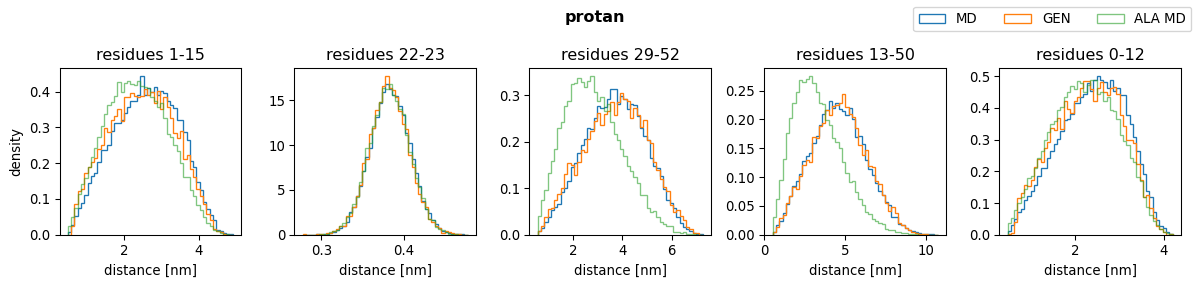

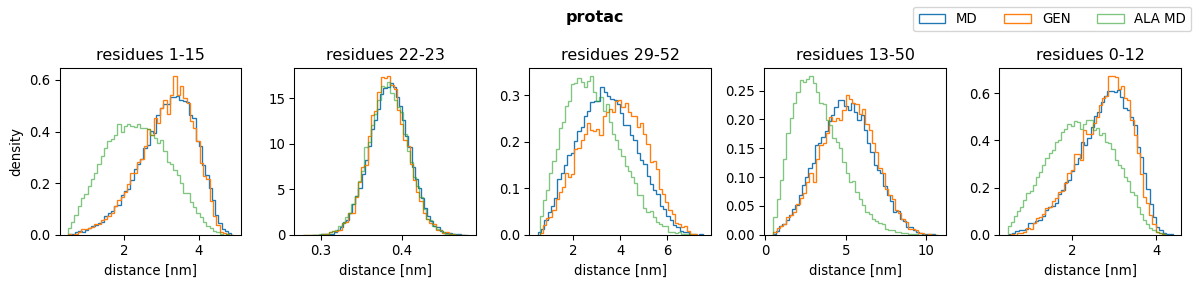

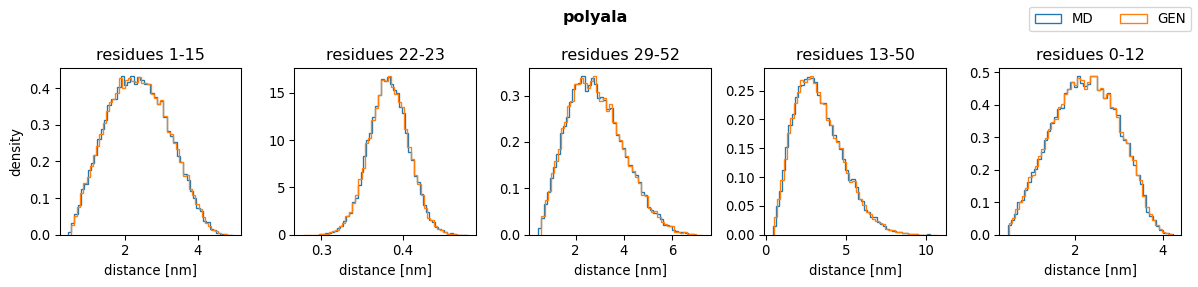

In [18]:
plot_distances_comparison(prot_data=(("protan", dmap_protan_md, dmap_protan_gen),
                                     ("protac", dmap_protac_md, dmap_protac_gen)),
                          polyala_data=(dmap_polyala_md, dmap_polyala_gen),
                          n_residues=55, n_hist=5)

Let's evaluate quantitatively the similarity between interatomic distance distributions. We will use the aKLD_d score, which is expressed as:

$aKLD_d = \frac{1}{N_{pairs}} \sum_{i<j} KLD(M_{ij} \parallel \hat{M}_{ij}),$

where $M_{ij}$ is the distribution of distances between atoms $i$ and $j$ in the MD data, $\hat{M}_{ij}$ is the predicted distance distribution for the same atoms and $KLD(M_{ij} \parallel \hat{M}_{ij})$ is an approximation of their [Kullback-Leibler divergence](https://en.wikipedia.org/wiki/Kullback–Leibler_divergence) (refer the [idpGAN article]() to see how this approximation is computed).

We first check how well the `polyala` MD distance distributions can approximate the `protan` and `protac` MD ones.

In [19]:
print("aKLD_d polyala MD vs protan MD:", score_akld_d(dmap_protan_md,
                                                      dmap_polyala_md))
print("aKLD_d polyala MD vs protac MD:", score_akld_d(dmap_protac_md,
                                                      dmap_polyala_md))

aKLD_d polyala MD vs protan MD: 0.15106640985754416
aKLD_d polyala MD vs protac MD: 0.395521811196272


Then we check how the idpGAN can approximate the MD distance distributions for `protan` and `protac`. Also for distances, idpGAN gives better approximations than `polyala`.

In [20]:
print("aKLD_d protan GEN vs protan MD:", score_akld_d(dmap_protan_md,
                                                      dmap_protan_gen))
print("aKLD_d protac GEN vs protac MD:", score_akld_d(dmap_protac_md,
                                                      dmap_protac_gen))

aKLD_d protan GEN vs protan MD: 0.010144712896590517
aKLD_d protac GEN vs protac MD: 0.016582804150243463


### Radius of gyration distribution

Finally, we will evaluate the distributions of [radius of gyration](https://en.wikipedia.org/wiki/Radius_of_gyration) (Rg) of our proteins.

Again, we see that idpGAN provides better approximations than polyala MD data for the `protan` and `protac` MD ensembles.

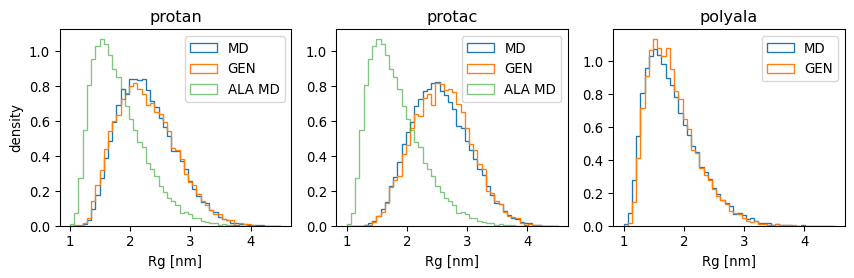

In [21]:
def compute_rg(xyz):
    """
    Adapted from the mdtraj library: https://github.com/mdtraj/mdtraj.
    """
    num_atoms = xyz.shape[1]
    masses = np.ones(num_atoms)
    weights = masses / masses.sum()
    mu = xyz.mean(1)
    centered = (xyz.transpose((1, 0, 2)) - mu).transpose((1, 0, 2))
    squared_dists = (centered ** 2).sum(2)
    Rg = (squared_dists * weights).sum(1) ** 0.5
    return Rg


rg_protan_md = compute_rg(xyz_protan_md)
rg_protac_md = compute_rg(xyz_protac_md)
rg_polyala_md = compute_rg(xyz_polyala_md)
rg_protan_gen = compute_rg(xyz_protan_gen)
rg_protac_gen = compute_rg(xyz_protac_gen)
rg_polyala_gen = compute_rg(xyz_polyala_gen)

plot_rg_comparison(prot_data=(("protan", rg_protan_md, rg_protan_gen),
                              ("protac", rg_protac_md, rg_protac_gen)),
                   polyala_data=(rg_polyala_md, rg_polyala_gen))

Let's finally evaluate quantitatively the similarity between Rg distributions. We will use the KLD_r score, based on an approximation of the [Kullback-Leibler divergence](https://en.wikipedia.org/wiki/Kullback–Leibler_divergence) (see the [idpGAN article]() for details).

We first check how the `polyala` MD Rg distributions can approximate the `protan` and `protac` MD ones.

In [22]:
print("KLD_r polyala MD vs protan MD:", score_kl_approximation(rg_protan_md,
                                                               rg_polyala_md)[0])
print("KLD_r polyala MD vs protac MD:", score_kl_approximation(rg_protac_md,
                                                               rg_polyala_md)[0])

KLD_r polyala MD vs protan MD: 0.508109788796592
KLD_r polyala MD vs protac MD: 1.1085768639588427


Then we check how the idpGAN can approximate the MD Rg distributions for `protan` and `protac`. Also for Rg values, idpGAN constitues a better approximation than `polyala`.

In [23]:
print("KLD_r protan MD vs protan MD:", score_kl_approximation(rg_protan_md,
                                                              rg_protan_gen)[0])
print("KLD_r protac MD vs protac MD:", score_kl_approximation(rg_protac_md,
                                                              rg_protac_gen)[0])

KLD_r protan MD vs protan MD: 0.007237764898791271
KLD_r protac MD vs protac MD: 0.008744099406135035


# 3 - Generate ensembles for a custom protein
Use the idpGAN generator to generate conformational ensembles for a user-defined sequence.

## Actually generate the xyz data

We first load again the idpGAN generator model and its weights here, in case you have skipped the cells above.

In [24]:
netg = load_netg_article(model_fp=os.path.join(data_dp, "generator.pt"),
                         device=device)

Set the number of samples to generate and the sequence of the protein.

In [32]:
# Number of samples in the ensemble to generate.
n_custom_samples = 5000
# Amino acid sequence for the custom protein. Feel free to change it!
custom_protein_name = "Q8GT36"
custom_seq = "MSSLPFVFGAAASSRVVTAAAAKGTAETKQEKSFVDWLLGKITKEDQFYETDPILRGGDVKSSGSTSGKKGGTTSGKKGTVSIPSKKKNGNGGVFGGLFAKKD"

# custom_seq = "K"*25 + "E"*25
# custom_seq = custom_seq*16

print("- custom protein length:", len(custom_seq))

- custom protein length: 103


Actually use the generator to sample conformations.

Note: for larger proteins, you should decrease the batch_size argument if you get out of memory errors (and also restart the kernel of the notebook to clear up memory).

In [33]:
xyz_custom_gen = netg.predict_idp(n_samples=n_custom_samples,
                                  aa_seq=custom_seq,
                                  device=device,
                                  batch_size=16).cpu().numpy()
print("- custom generated xyz data:", xyz_custom_gen.shape)

- custom generated xyz data: (5000, 103, 3)


## Visualize some properties of the generated ensemble

Let's visualize some properties of the generated conformational ensemble.

In [34]:
dmap_custom_gen = get_distance_matrix(xyz_custom_gen)
cmap_custom_gen = get_contact_map(dmap_custom_gen)
rg_custom_gen = compute_rg(xyz_custom_gen)

Visualize the average distance map.

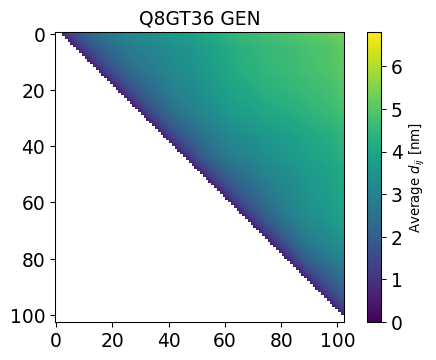

In [35]:
plot_average_dmap_comparison(dmap_ref=None, dmap_gen=dmap_custom_gen,
                             title="%s GEN" % custom_protein_name)

Visualize the contacp map.

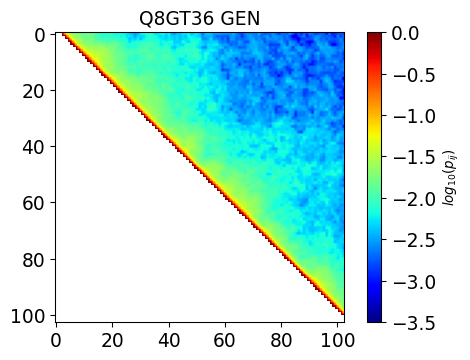

In [36]:
plot_cmap_comparison(cmap_ref=None, cmap_gen=cmap_custom_gen,
                     title="%s GEN" % custom_protein_name)

Visualize the distribution of radius of gyration.

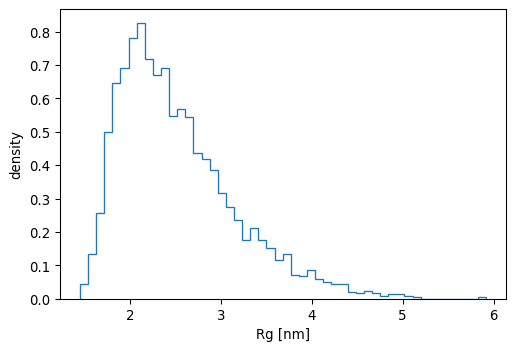

In [30]:
plot_rg_distribution(rg_vals=rg_custom_gen,
                     title="%s GEN" % custom_protein_name,
                     n_bins=50)

Visualize the distance maps of some random snapshots.

Each time you run the cell, you will plot different snapshots.

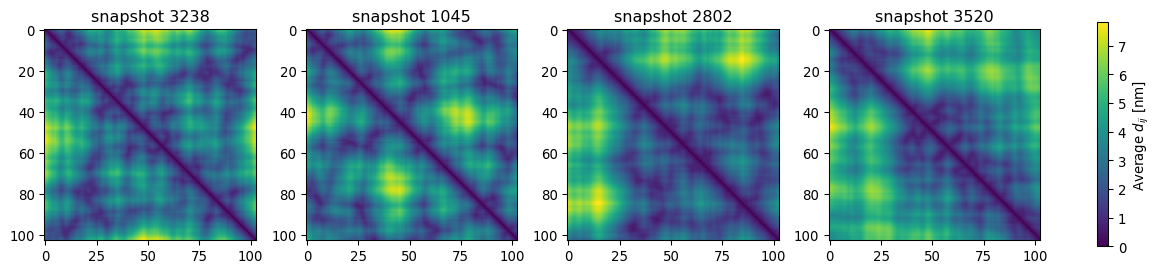

In [31]:
plot_dmap_snapshots(dmap=dmap_custom_gen,
                    title="%s GEN" % custom_protein_name,
                    n_snapshots=4)

Visualize the 3D ensemble.

In [ ]:
try:
    import google.colab
    from google.colab import output
    output.enable_custom_widget_manager()
except ImportError:
    pass

